In [ ]:
# unified_model_training.ipynb (Updated for Revised Preprocessing)

# # Cell 1: Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')


In [1]:

# Cell 2: Import Libraries
import os
import time
import torch
import pickle
import random
import numpy as np
import torch.nn as nn
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction,corpus_bleu


In [2]:

# Cell 3: Paths and Device
video_pairs_path = 'msrvtt_data/frame_caption_pairs.pkl'
image_pairs_path = 'flicker/image_caption_pairs.pkl'
vocab_path = 'vocab.pkl'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [4]:

# Cell 4: Dataset Class
class CaptionDataset(Dataset):
    def __init__(self, data_pairs, vocab, transform=None):
        self.data = data_pairs
        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, caption = self.data[idx]
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        tokens = [self.vocab['<start>']] + [self.vocab.get(word, self.vocab['<unk>']) for word in caption.lower().split()] + [self.vocab['<end>']]
        return image, torch.tensor(tokens)


In [5]:

# Cell 5: Transforms
transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [6]:

# Cell 6: Load Datasets and Vocabulary
with open(video_pairs_path, 'rb') as f:
    video_data = pickle.load(f)

with open(image_pairs_path, 'rb') as f:
    image_data = pickle.load(f)

with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

inv_vocab = {idx: word for word, idx in vocab.items()}
data_pairs = video_data + image_data
dataset = CaptionDataset(data_pairs, vocab, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))


In [7]:

# CELL:6.1: validation loader & train loader
train_pairs, val_pairs = train_test_split(data_pairs, test_size=0.1, random_state=42)

train_dataset = CaptionDataset(train_pairs, vocab, transform)
val_dataset = CaptionDataset(val_pairs, vocab, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [8]:

# Cell 7: Encoder
# class EncoderCNN(nn.Module):
#     def __init__(self, embed_size):
#         super(EncoderCNN, self).__init__()
#         resnet = models.resnet50(pretrained=True)
#         resnet.fc = nn.Identity()  # remove final FC layer
#         modules = list(resnet.children())[:-2]
#         self.resnet = nn.Sequential(*modules) # ResNet50 without the last two layers
#         self.linear = nn.Linear(resnet.fc.in_features, embed_size)
#         self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

#     def forward(self, images):
#         with torch.no_grad():
#             features = self.resnet(images)  # shape: (batch_size, 2048, 1, 1)
#             features = features.squeeze(-1).squeeze(-1)  # shape: (batch_size, 2048)
#         features = self.bn(self.linear(features))  # shape: (batch_size, embed_size)
#         return features

import torch.nn.functional as F

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]  # Remove last FC and avgpool
        self.resnet = nn.Sequential(*modules)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # to get 2048-dim
        self.linear = nn.Linear(2048, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

    def forward(self, inputs):
        """
        inputs: (B, C, H, W) for image or (B, T, C, H, W) for video
        """
        if inputs.dim() == 4:  # Single image
            with torch.no_grad():
                features = self.resnet(inputs)  # (B, 2048, H', W')
                features = self.pool(features).squeeze(-1).squeeze(-1)  # (B, 2048)
            features = self.linear(features)  # (B, embed_size)
            features = self.bn(features)
            return features
        
        elif inputs.dim() == 5:  # Video: (B, T, C, H, W)
            B, T, C, H, W = inputs.size()
            inputs = inputs.view(B * T, C, H, W)
            with torch.no_grad():
                features = self.resnet(inputs)  # (B*T, 2048, H', W')
                features = self.pool(features).squeeze(-1).squeeze(-1)  # (B*T, 2048)
            features = self.linear(features)  # (B*T, embed_size)
            features = self.bn(features)
            features = features.view(B, T, -1)  # (B, T, embed_size)
            features = features.mean(dim=1)  # aggregate frame features (B, embed_size)
            return features

        else:
            raise ValueError("Unsupported input shape for EncoderCNN")

In [9]:

# Cell 8: Decoder
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, dropout=0.5):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.init_h = nn.Linear(embed_size, hidden_size)
        self.init_c = nn.Linear(embed_size, hidden_size)

    def forward(self, features, captions):
        embeddings = self.embedding(captions[:, :-1])
        h0 = self.init_h(features).unsqueeze(0)
        c0 = self.init_c(features).unsqueeze(0)
        hiddens, _ = self.lstm(embeddings, (h0, c0))
        outputs = self.linear(self.dropout(hiddens))
        return outputs

    def sample(self, features, max_len=20, beam_width=3):
        """ Beam Search Decoding """
        vocab_size = self.embedding.num_embeddings
        device = features.device
        sequences = [[[], 0.0, (self.init_h(features).unsqueeze(0), self.init_c(features).unsqueeze(0))]]

        for _ in range(max_len):
            all_candidates = []
            for seq, score, (h, c) in sequences:
                input_token = torch.tensor([[vocab['<start>']] if not seq else [seq[-1]]], device=device)
                embedded = self.embedding(input_token)
                output, (h1, c1) = self.lstm(embedded, (h, c))
                output = self.linear(output.squeeze(1))
                log_probs = F.log_softmax(output, dim=-1)
                topk_log_probs, topk_idx = log_probs.topk(beam_width)

                for i in range(beam_width):
                    candidate = seq + [topk_idx[0][i].item()]
                    candidate_score = score + topk_log_probs[0][i].item()
                    all_candidates.append((candidate, candidate_score, (h1, c1)))

            sequences = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)[:beam_width]

        return sequences[0][0]  # Return best sequence


In [10]:

# Cell 9: Initialize and Train Model
embed_size = 256
hidden_size = 512
vocab_size = len(vocab)

encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size).to(device)

params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4, weight_decay=1e-5)

def compute_bleu(references, candidates):
    smoothie = SmoothingFunction().method4
    return corpus_bleu([[ref] for ref in references], candidates, smoothing_function=smoothie)



c:\Users\Nikhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Nikhil\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:

# from tqdm.notebook import tqdm

# num_epochs = 30
# best_val_acc = 0.0
# losses = []
# accuracies = []
# bleu_scores = []

# for epoch in range(num_epochs):
#     encoder.train()
#     decoder.train()
#     total_loss = 0
#     total_correct = 0
#     total_words = 0

#     print(f"\n[Epoch {epoch + 1}/{num_epochs}]")
#     train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

#     for batch_idx, (images, captions) in train_loop:
#         images = torch.stack(images).to(device)
#         captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab['<pad>']).to(device)

#         features = encoder(images)
#         outputs = decoder(features, captions)

#         targets = captions[:, 1:]
#         outputs = outputs[:, :targets.size(1), :]

#         loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
#         predicted = outputs.argmax(2)
#         mask = targets != vocab['<pad>']
#         correct = (predicted == targets) & mask
#         total_correct += correct.sum().item()
#         total_words += mask.sum().item()

#         acc = 100 * total_correct / total_words
#         train_loop.set_description(f"[Batch {batch_idx + 1} / {len(train_loader)}] [Loss: {loss.item():.6f}, Acc: {acc:.2f}%]")

#     # Epoch summary
#     epoch_loss = total_loss / len(train_loader)
#     epoch_acc = total_correct / total_words
#     losses.append(epoch_loss)
#     accuracies.append(epoch_acc)

#     print("Testing")
#     encoder.eval()
#     decoder.eval()
#     test_loss = 0
#     test_correct = 0
#     test_words = 0
#     references = []
#     candidates = []

#     val_loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)
#     with torch.no_grad():
#         for test_batch_idx, (images, captions) in val_loop:
#             images = torch.stack(images).to(device)
#             captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab['<pad>']).to(device)

#             features = encoder(images)
#             outputs = decoder(features, captions)

#             targets = captions[:, 1:]
#             outputs = outputs[:, :targets.size(1), :]

#             loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
#             predicted = outputs.argmax(2)
#             mask = targets != vocab['<pad>']
#             correct = (predicted == targets) & mask
#             test_correct += correct.sum().item()
#             test_words += mask.sum().item()

#             acc = 100 * test_correct / test_words
#             val_loop.set_description(f"[Batch {test_batch_idx + 1} / {len(val_loader)}]  [Loss: {loss.item():.6f}, Acc: {acc:.2f}%]")

#             for pred_seq, target_seq in zip(predicted, targets):
#                 pred_tokens = [inv_vocab[idx.item()] for idx in pred_seq if idx.item() not in {vocab['<pad>'], vocab['<end>']}]
#                 target_tokens = [inv_vocab[idx.item()] for idx in target_seq if idx.item() not in {vocab['<pad>'], vocab['<end>']}]
#                 candidates.append(pred_tokens)
#                 references.append(target_tokens)

#     val_acc = 100 * test_correct / test_words
#     bleu_score = compute_bleu(references, candidates)
#     bleu_scores.append(bleu_score)

#     print(f"Accuracy {val_acc:.8f}")

#     print(f"[Epoch {epoch+1}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc*100:.2f}%")
#     print(f"Validation Acc: {val_acc:.2f}%, BLEU Score: {bleu_score:.4f}")

#     # Save checkpoint
#     checkpoint = {
#         'epoch': epoch + 1,
#         'encoder_state_dict': encoder.state_dict(),
#         'decoder_state_dict': decoder.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'val_accuracy': val_acc,
#         'vocab': vocab
#     }
#     torch.save(checkpoint, f"checkpoint_epoch_{epoch+1}.pt")

#     # Save best model
#     if val_acc > best_val_acc:
#         best_val_acc = val_acc
#         torch.save(checkpoint, "best_model.pt")
#         print("✅ Best model saved.\n")

# # Final save
# torch.save(encoder.state_dict(), 'unified_encoder.pth')
# torch.save(decoder.state_dict(), 'unified_decoder.pth')
# torch.save({
#     'encoder_state_dict': encoder.state_dict(),
#     'decoder_state_dict': decoder.state_dict(),
#     'vocab': vocab
# }, 'unified_model_epoch_30.pth')

# print("\n📦 Unified model saved as 'unified_model_epoch_30.pth'")
# print(f"🏆 Best Accuracy: {max(accuracies) * 100:.2f}%")
# print(f"📈 Final Accuracy: {accuracies[-1] * 100:.2f}%")
# print(f"📝 Final BLEU Score: {bleu_scores[-1]:.4f}")
# print("Training complete.")


In [ ]:

import os
import torch
from tqdm.notebook import tqdm

# Define your model, loss function, optimizer, and other variables
# These should be initialized before this code snippet
# e.g., encoder, decoder, optimizer, criterion, vocab, etc.

num_epochs = 30
best_val_acc = 0.0
losses = []
accuracies = []
bleu_scores = []
checkpoint_dir = './checkpoints/'  # Directory where checkpoints are saved

# Find the latest checkpoint
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]

# Print out filenames to understand the format
print("Checkpoint files in directory:", checkpoint_files)

# If filenames are like "checkpoint_epoch_X.pt", sort by the epoch number
try:
    # Sort files based on the epoch number found in the filename (assuming format "checkpoint_epoch_X.pt")
    checkpoint_files = sorted(checkpoint_files, key=lambda x: int(x.split('_')[2].split('.')[0]))
    latest_checkpoint = checkpoint_files[-1] if checkpoint_files else None
except IndexError as e:
    print("Error parsing filenames. Please check the filenames of your checkpoints.")
    raise e

# Initialize start_epoch to 0 if no checkpoint is found
start_epoch = 0

for ckpt_file in checkpoint_files:
    path = os.path.join(checkpoint_dir, ckpt_file)
    checkpoint = torch.load(path)
    epoch_num = checkpoint.get('epoch', 'N/A')
    val_acc = checkpoint.get('val_accuracy', 'N/A')
    losses = checkpoint.get('losses', [])
    accuracies = checkpoint.get('accuracies', [])
    bleu_scores = checkpoint.get('bleu_scores', [])
    
    print(f"\nCheckpoint: {ckpt_file}")
    print(f"Epoch: {epoch_num}")
    print(f"Accuracy: {val_acc:.8f}%" if isinstance(val_acc, float) else f"Accuracy: {val_acc}")
    if losses:
        print(f"Train Loss: {losses[-1]:.4f} ,")
    if accuracies:
        print(f"Train Accuracy: {accuracies[-1]*100:.2f}% ,")
        print(f" Validation Accuracy:{val_acc:.8f}% ,")
    if bleu_scores:
        print(f"BLEU Score: {bleu_scores[-1]:.4f}")
        print("✅ Best model saved.")

if latest_checkpoint:
    print(f"Found checkpoint '{latest_checkpoint}', resuming from epoch {latest_checkpoint.split('_')[2].split('.')[0]}...")
    checkpoint = torch.load(os.path.join(checkpoint_dir, latest_checkpoint))
    start_epoch = checkpoint['epoch']  # Start from the saved epoch
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    best_val_acc = checkpoint['val_accuracy']
    
    # Load losses, accuracies, and bleu_scores if they exist in the checkpoint
    losses = checkpoint.get('losses', [])
    accuracies = checkpoint.get('accuracies', [])
    bleu_scores = checkpoint.get('bleu_scores', [])
    
    print(f"Resuming from epoch {start_epoch}")
else:
    print("No checkpoint found. Starting from scratch.")

# Training loop
for epoch in range(start_epoch, num_epochs):
    encoder.train()
    decoder.train()
    total_loss = 0
    total_correct = 0
    total_words = 0

    print(f"\n[Epoch {epoch + 1}/{num_epochs}]")
    train_loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

    for batch_idx, (images, captions) in train_loop:
        images = torch.stack(images).to(device)
        captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab['<pad>']).to(device)

        features = encoder(images)
        outputs = decoder(features, captions)

        targets = captions[:, 1:]
        outputs = outputs[:, :targets.size(1), :]

        loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted = outputs.argmax(2)
        mask = targets != vocab['<pad>']
        correct = (predicted == targets) & mask
        total_correct += correct.sum().item()
        total_words += mask.sum().item()

        acc = 100 * total_correct / total_words
        train_loop.set_description(f"[Batch {batch_idx + 1} / {len(train_loader)}] [Loss: {loss.item():.6f}, Acc: {acc:.2f}%]")

    # Epoch summary
    epoch_loss = total_loss / len(train_loader)
    epoch_acc = total_correct / total_words
    losses.append(epoch_loss)
    accuracies.append(epoch_acc)

    print("Testing")
    encoder.eval()
    decoder.eval()
    test_loss = 0
    test_correct = 0
    test_words = 0
    references = []
    candidates = []

    val_loop = tqdm(enumerate(val_loader), total=len(val_loader), leave=False)
    with torch.no_grad():
        for test_batch_idx, (images, captions) in val_loop:
            images = torch.stack(images).to(device)
            captions = nn.utils.rnn.pad_sequence(captions, batch_first=True, padding_value=vocab['<pad>']).to(device)

            features = encoder(images)
            outputs = decoder(features, captions)

            targets = captions[:, 1:]
            outputs = outputs[:, :targets.size(1), :]

            loss = criterion(outputs.reshape(-1, vocab_size), targets.reshape(-1))
            predicted = outputs.argmax(2)
            mask = targets != vocab['<pad>']
            correct = (predicted == targets) & mask
            test_correct += correct.sum().item()
            test_words += mask.sum().item()

            acc = 100 * test_correct / test_words
            val_loop.set_description(f"[Batch {test_batch_idx + 1} / {len(val_loader)}]  [Loss: {loss.item():.6f}, Acc: {acc:.2f}%]")

            for pred_seq, target_seq in zip(predicted, targets):
                pred_tokens = [inv_vocab[idx.item()] for idx in pred_seq if idx.item() not in {vocab['<pad>'], vocab['<end>']}]
                target_tokens = [inv_vocab[idx.item()] for idx in target_seq if idx.item() not in {vocab['<pad>'], vocab['<end>']}]
                candidates.append(pred_tokens)
                references.append(target_tokens)

    val_acc = 100 * test_correct / test_words
    bleu_score = compute_bleu(references, candidates)
    bleu_scores.append(bleu_score)

    print(f"Accuracy {val_acc:.8f}")

    print(f"[Epoch {epoch+1}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc*100:.2f}%")
    print(f"Validation Acc: {val_acc:.2f}%, BLEU Score: {bleu_score:.4f}")

    # Save checkpoint
    checkpoint = {
        'epoch': epoch + 1,
        'encoder_state_dict': encoder.state_dict(),
        'decoder_state_dict': decoder.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_accuracy': val_acc,
        'train_accuracy': epoch_acc,  # ✅ Added train accuracy
        'vocab': vocab,
        'losses': losses,
        'accuracies': accuracies,
        'bleu_scores': bleu_scores
    }
    
    torch.save(checkpoint, os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch+1}.pt"))

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(checkpoint, os.path.join(checkpoint_dir, "best_model.pt"))
        print("✅ Best model saved.\n")

# Final save
torch.save(encoder.state_dict(), 'unified_encoder.pth')
torch.save(decoder.state_dict(), 'unified_decoder.pth')
torch.save({
    'encoder_state_dict': encoder.state_dict(),
    'decoder_state_dict': decoder.state_dict(),
    'vocab': vocab
}, 'unified_model_epoch_30.pth')

print("\n📦 Unified model saved as 'unified_model_epoch_30.pth'")
print(f"🏆 Best Accuracy: {max(accuracies) * 100:.2f}%")
print(f"📈 Final Accuracy: {accuracies[-1] * 100:.2f}%")
print(f"📝 Final BLEU Score: {bleu_scores[-1]:.4f}")
print("Training complete.")


Checkpoint files in directory: ['checkpoint_epoch_1.pt', 'checkpoint_epoch_10.pt', 'checkpoint_epoch_11.pt', 'checkpoint_epoch_12.pt', 'checkpoint_epoch_13.pt', 'checkpoint_epoch_14.pt', 'checkpoint_epoch_15.pt', 'checkpoint_epoch_16.pt', 'checkpoint_epoch_17.pt', 'checkpoint_epoch_18.pt', 'checkpoint_epoch_19.pt', 'checkpoint_epoch_2.pt', 'checkpoint_epoch_20.pt', 'checkpoint_epoch_21.pt', 'checkpoint_epoch_22.pt', 'checkpoint_epoch_23.pt', 'checkpoint_epoch_24.pt', 'checkpoint_epoch_25.pt', 'checkpoint_epoch_3.pt', 'checkpoint_epoch_4.pt', 'checkpoint_epoch_5.pt', 'checkpoint_epoch_6.pt', 'checkpoint_epoch_7.pt', 'checkpoint_epoch_8.pt', 'checkpoint_epoch_9.pt']


C:\Users\Nikhil\AppData\Local\Temp\ipykernel_13232\1293588966.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)



Checkpoint: checkpoint_epoch_1.pt
Epoch: 1
Accuracy: 34.39536975%
Train Loss: 4.5532 ,
Train Accuracy: 29.66% ,
 Validation Accuracy:34.39536975% ,
BLEU Score: 0.0480
✅ Best model saved.

Checkpoint: checkpoint_epoch_2.pt
Epoch: 2
Accuracy: 37.50168577%
Train Loss: 3.6777 ,
Train Accuracy: 36.30% ,
 Validation Accuracy:37.50168577% ,
BLEU Score: 0.0585
✅ Best model saved.

Checkpoint: checkpoint_epoch_3.pt
Epoch: 3
Accuracy: 39.40211283%
Train Loss: 3.3242 ,
Train Accuracy: 38.82% ,
 Validation Accuracy:39.40211283% ,
BLEU Score: 0.0608
✅ Best model saved.

Checkpoint: checkpoint_epoch_4.pt
Epoch: 4
Accuracy: 40.91368847%
Train Loss: 3.0744 ,
Train Accuracy: 40.76% ,
 Validation Accuracy:40.91368847% ,
BLEU Score: 0.0673
✅ Best model saved.

Checkpoint: checkpoint_epoch_5.pt
Epoch: 5
Accuracy: 42.34659474%
Train Loss: 2.8694 ,
Train Accuracy: 42.52% ,
 Validation Accuracy:42.34659474% ,
BLEU Score: 0.0721
✅ Best model saved.

Checkpoint: checkpoint_epoch_6.pt
Epoch: 6
Accuracy: 43.691

C:\Users\Nikhil\AppData\Local\Temp\ipykernel_13232\1293588966.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, lates

Resuming from epoch 25

[Epoch 26/30]


  0%|          | 0/2123 [00:00<?, ?it/s]

Testing


  0%|          | 0/236 [00:00<?, ?it/s]

Accuracy 60.42930996
[Epoch 26] Train Loss: 1.2420, Train Acc: 70.29%
Validation Acc: 60.43%, BLEU Score: 0.2392
✅ Best model saved.


[Epoch 27/30]


  0%|          | 0/2123 [00:00<?, ?it/s]

Testing


  0%|          | 0/236 [00:00<?, ?it/s]

Accuracy 60.75634974
[Epoch 27] Train Loss: 1.2113, Train Acc: 70.85%
Validation Acc: 60.76%, BLEU Score: 0.2360
✅ Best model saved.


[Epoch 28/30]


  0%|          | 0/2123 [00:00<?, ?it/s]

Testing


  0%|          | 0/236 [00:00<?, ?it/s]

Accuracy 60.73274893
[Epoch 28] Train Loss: 1.1801, Train Acc: 71.53%
Validation Acc: 60.73%, BLEU Score: 0.2403

[Epoch 29/30]


  0%|          | 0/2123 [00:00<?, ?it/s]

Testing


  0%|          | 0/236 [00:00<?, ?it/s]

Accuracy 60.83501911
[Epoch 29] Train Loss: 1.1513, Train Acc: 72.08%
Validation Acc: 60.84%, BLEU Score: 0.2520
✅ Best model saved.


[Epoch 30/30]


  0%|          | 0/2123 [00:00<?, ?it/s]

Testing


  0%|          | 0/236 [00:00<?, ?it/s]

Accuracy 61.23061362
[Epoch 30] Train Loss: 1.1223, Train Acc: 72.70%
Validation Acc: 61.23%, BLEU Score: 0.2408
✅ Best model saved.


📦 Unified model saved as 'unified_model_epoch_31.pth'
🏆 Best Accuracy: 72.70%
📈 Final Accuracy: 72.70%
📝 Final BLEU Score: 0.2408
Training complete.


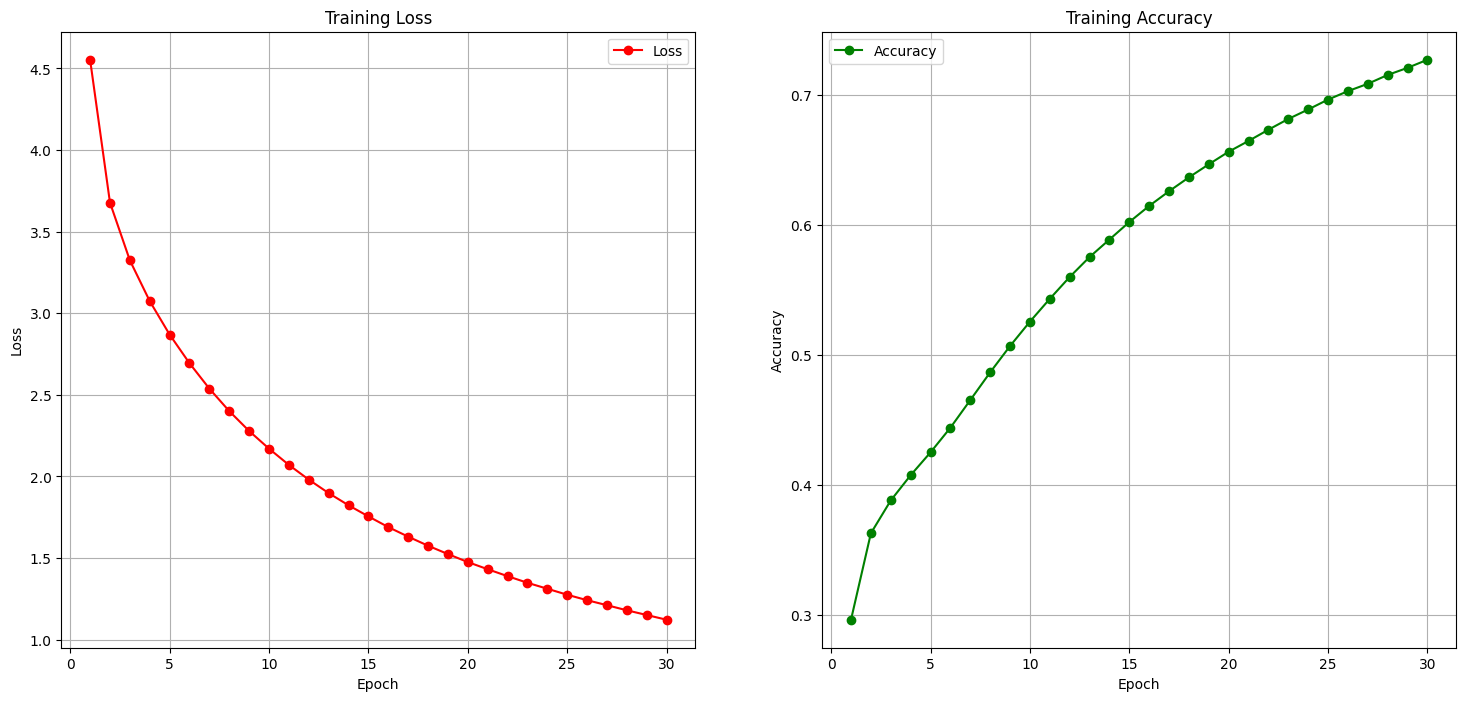

In [ ]:
# Plot the training loss, accuracy, and BLEU score
plt.figure(figsize=(18, 8))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(losses) + 1), losses,color='red', marker='o', label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', color='green', label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()



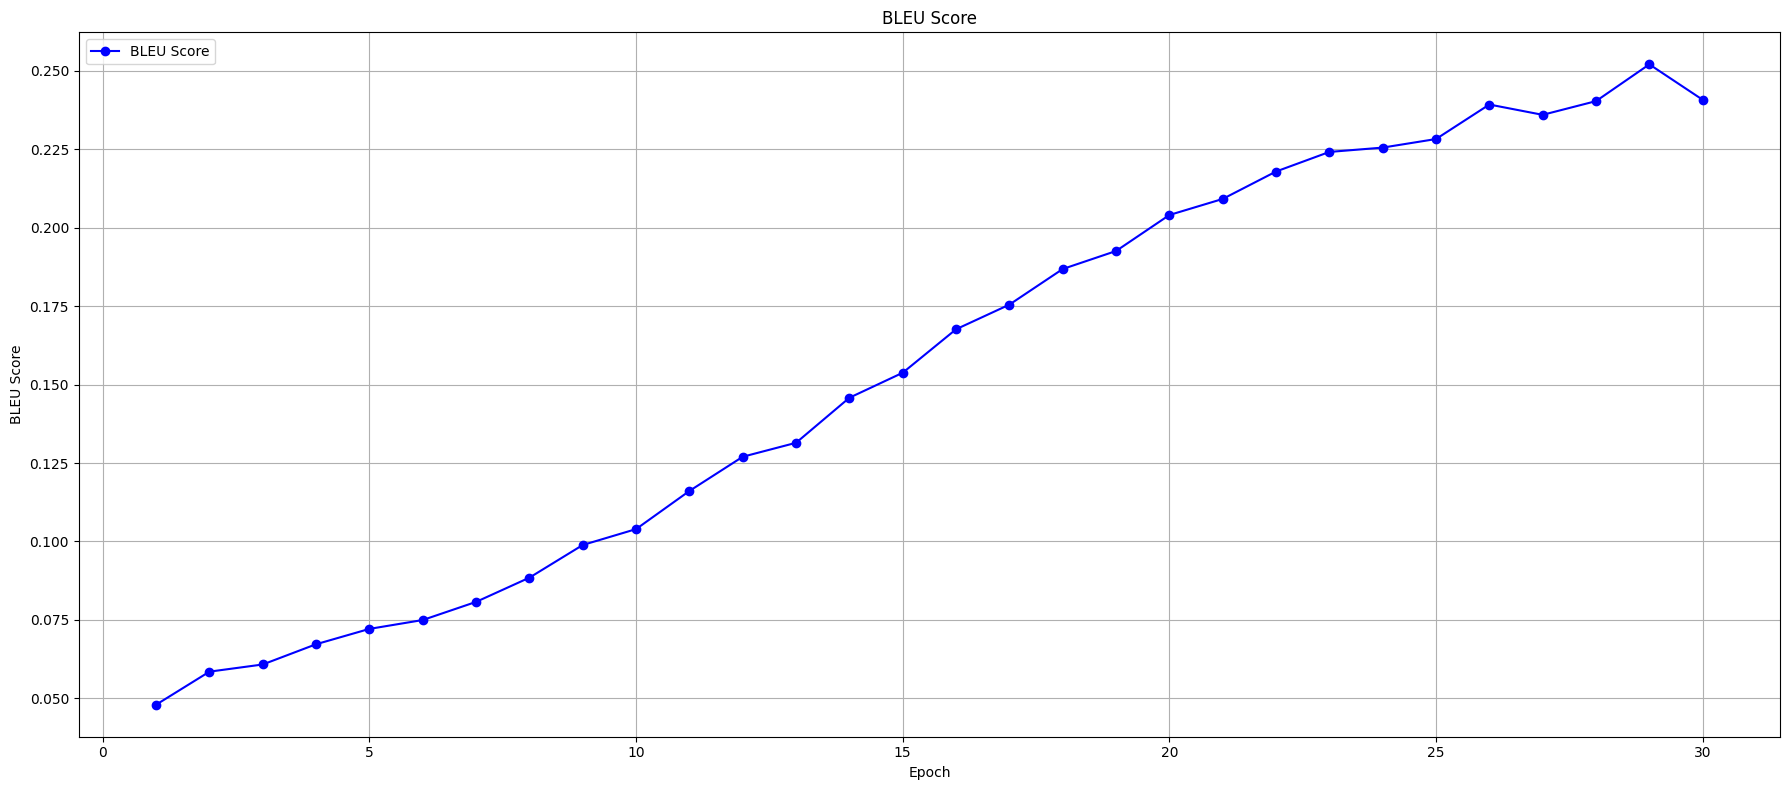

In [ ]:

# BLEU Score Plot
plt.figure(figsize=(18, 8))
plt.subplot(1, 1, 1)
plt.plot(range(1, len(bleu_scores) + 1), bleu_scores, marker='o', color='blue', label='BLEU Score')
plt.title('BLEU Score')
plt.xlabel('Epoch')
plt.ylabel('BLEU Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


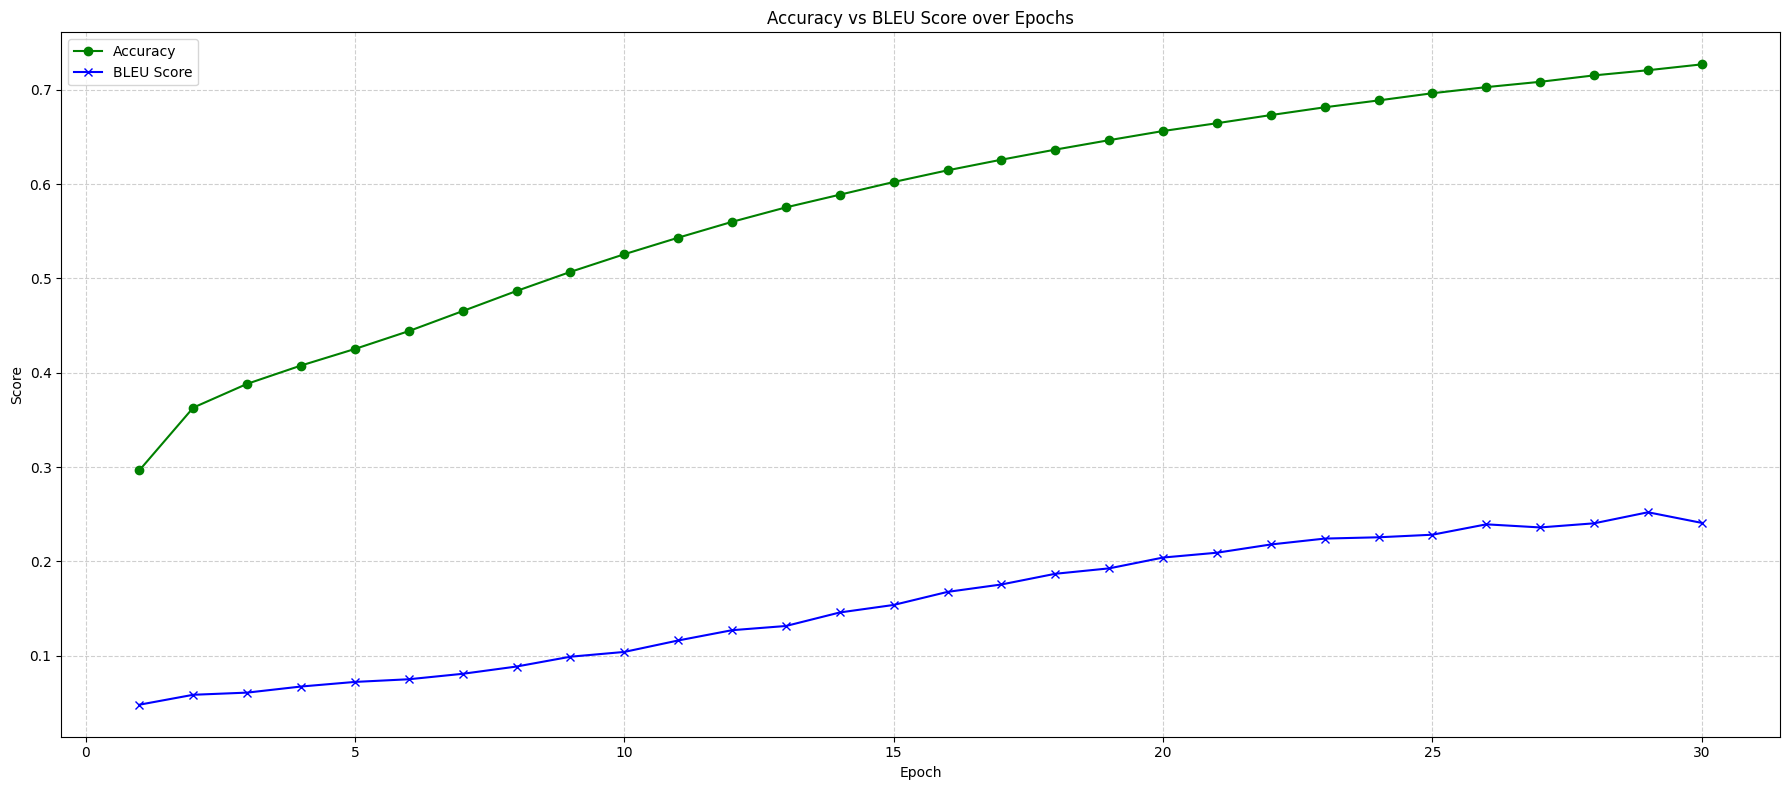

In [ ]:

epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(18, 8))

plt.plot(epochs, accuracies, label="Accuracy", color='green', marker='o')
plt.plot(epochs, bleu_scores, label="BLEU Score", color='blue', marker='x')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Accuracy vs BLEU Score over Epochs")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
